In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib

notation = 'pyrimidine'
hg38_path = '/home/clint/buffalo/hg38/hg38.fa'
cosmic_mutants = '/home/clint/buffalo/cosmic/v76/CosmicMutantExport_LiverHCC.tsv'

Load Human Genome into Memory for Fast Random Access
---

In [2]:
from siglib.utils import fasta

hg38 = fasta('/home/clint/buffalo/ref/hg38/hg38.fa')

Generate HCC Samples and Merge based on Name
---

In [3]:
from siglib.cosmic import parse_to_samples

samples = parse_to_samples(cosmic_mutants)

In [4]:
from siglib.cosmic import merge_samples

merged_samples = merge_samples(samples)

Get Trinucleotide Context
---

In [5]:
for sample in merged_samples.values():
    for mutation in sample.mutations:
        mutation.set_context(hg38, notation=notation)

Lookup Table
---

In [6]:
from siglib.cosmic import lookup_table

lookup = lookup_table(samples.values())

In [7]:
from siglib.utils import Spectrum

for id, sample in merged_samples.items():
    
    merged_samples[id].spectrum_count = Spectrum(notation=notation)
    merged_samples[id].proportion = Spectrum(notation=notation)

    for mutation in sample.mutations:
        if mutation.label is not '':
            merged_samples[id].spectrum_count[(mutation.label[2:5], mutation.context)] += 1
    total = sum(list(merged_samples[id].spectrum_count.values()))
    if total > 0:
        for label, number in merged_samples[id].spectrum_count.items():
            merged_samples[id].proportion[label] = number / total
            
try:
    del merged_samples['CHC892T']
except KeyError:
    pass

Normalize
---

In [8]:
from siglib.utils import dna_bases

from jellywrap import Jellyfish, dna_notation
merfile = '/home/clint/essigmann_analysis/AFB1/data/9606_exons.jf'

j = Jellyfish()
mer, tally = j.read_mer_file(merfile)

mer = [dna_notation(m, 'pyrimidine', pos=1) for m in mer]
normal = dict(zip(mer, tally))

for sample in merged_samples.values():
    sample.spectrum_count.normalized_proportion(normal)

In [9]:
from collections import Counter
num_mutations = Counter()

for i, sample in merged_samples.items():
    num_mutations.update([len(sample.mutations)])
    
results = []
for i, sample in merged_samples.items():
    if len(sample.mutations) < 100:
        continue
    else:
        results.append(sample)

In [10]:
del hg38

In [11]:
aflatoxin_cluster_names = ['067T','TCGA-CC-A7IL-01','TCGA-CC-A7II-01',
                           'TCGA-CC-A7IG-01','TCGA-DD-A1EL-01','CHC1704T',
                           'CHC1211T','CHC1754T','3206A7_009_T','CHC1154T',
                           'CHC1717T','3206A7_017_T','TCGA-DD-A114-01']

stratton_cluster = ['CHC1154T', 'CHC1211T', 'CHC1704T',
                           'CHC1717T','CHC1754T', 'TCGA-CC-A5UE-01',
                           'TCGA-CC-A7IG-01', 'TCGA-CC-A7II-01' ,
                           'TCGA-CC-A7IL-01', 'TCGA-DD-A114-01',
                           'TCGA-DD-A1EL-01']

In [12]:
from siglib.utils import load_dataset

C10 = load_dataset('aflatoxin_10wk_average').values[0]


14


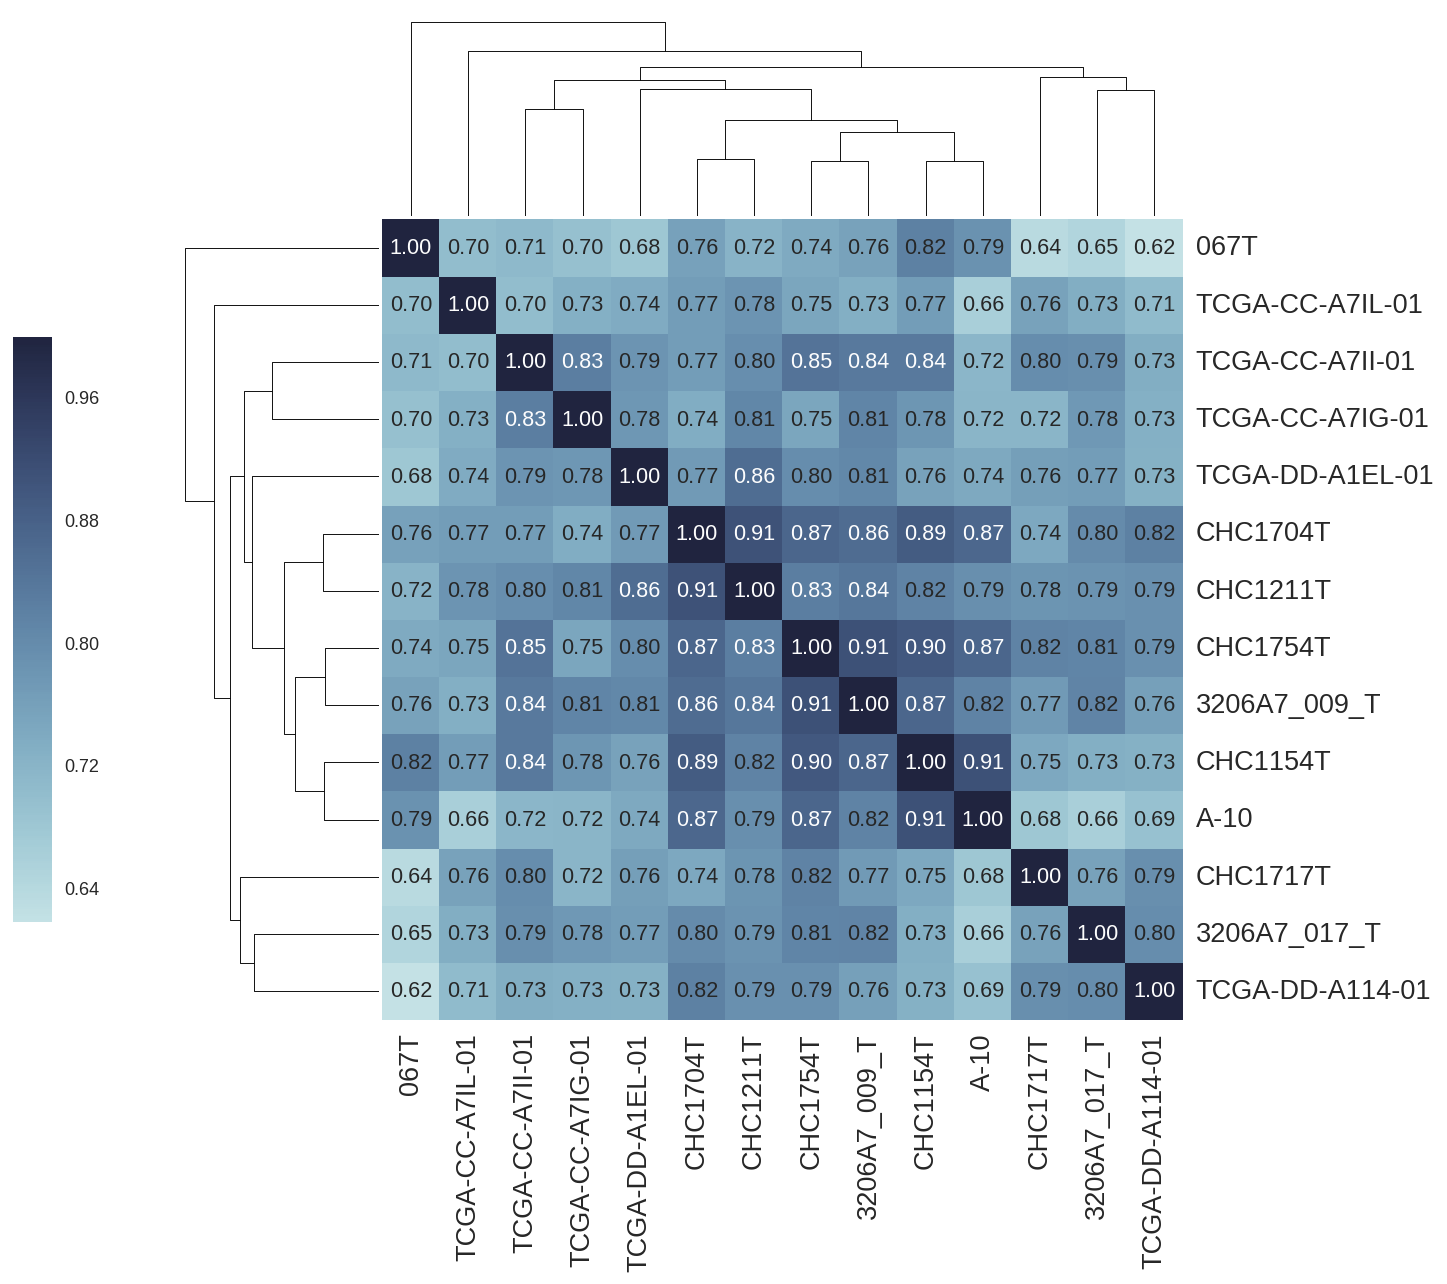

In [13]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage
from sklearn.metrics.pairwise import cosine_similarity
matplotlib.rcParams['lines.linewidth'] = 10
aflatoxin_cluster_names = ['067T','TCGA-CC-A7IL-01','TCGA-CC-A7II-01',
                           'TCGA-CC-A7IG-01','TCGA-DD-A1EL-01','CHC1704T',
                           'CHC1211T','CHC1754T','3206A7_009_T','CHC1154T',
                           'CHC1717T','3206A7_017_T','TCGA-DD-A114-01']

stratton_cluster = ['CHC1154T', 'CHC1211T', 'CHC1704T',
                           'CHC1717T','CHC1754T', 'TCGA-CC-A5UE-01',
                           'TCGA-CC-A7IG-01', 'TCGA-CC-A7II-01' ,
                           'TCGA-CC-A7IL-01', 'TCGA-DD-A114-01',
                           'TCGA-DD-A1EL-01']
x = [list(merged_samples[name].spectrum_count.normalized_proportion(normal)) for name in aflatoxin_cluster_names]
x.append(C10)

print(len(x))
pdist = cosine_similarity(x)

distances = pd.DataFrame(pdist, columns=aflatoxin_cluster_names + ['A-10'], index=aflatoxin_cluster_names  + ['A-10'])
linkages = linkage(x, method='weighted', metric='cosine')
cmap = sns.cubehelix_palette(start=9, rot=-0.2, dark=0.15, light=.85, as_cmap=True)
grid = sns.clustermap(distances,fmt='.2f', method='weighted', cmap=cmap, annot=True, row_linkage=linkages, col_linkage=linkages, row_cluster=True, col_cluster=True)
size = 15
_ = grid.ax_heatmap.set_xticklabels(grid.ax_heatmap.get_xticklabels(), size=size)
_ = grid.ax_heatmap.set_yticklabels(grid.ax_heatmap.get_yticklabels(), size=size, rotation=0)
grid.cax.set_position([0, .2, .03, .45])

for l in grid.ax_row_dendrogram.lines:
        l.set_linewidth(1.25)
for l in grid.ax_col_dendrogram.lines:
        l.set_linewidth(1.25)
for t in grid.ax_heatmap.texts:
    t.set_fontsize(12)

plt.savefig('heatmap.pdf', dpi=450, bbox_inches='tight')

[[0.9312692223325372, 0.8201921796082118, 0.7971480974663592],
 [0.8888663743660877, 0.7106793139856472, 0.7158661451411206],
 [0.8314793143949643, 0.5987041921652179, 0.6530062709235388],
 [0.7588951019517731, 0.49817117746394224, 0.6058723814510268],
 [0.6672565752652589, 0.40671838146419587, 0.5620016466433286],
 [0.5529215689527474, 0.3217924564263954, 0.5093718054521851],
 [0.43082755198027817, 0.24984535814964698, 0.44393960899639856],
 [0.29794615023641036, 0.18145907625614888, 0.35317781405034754],
 [0.1750865648952205, 0.11840023306916837, 0.24215989137836502]]

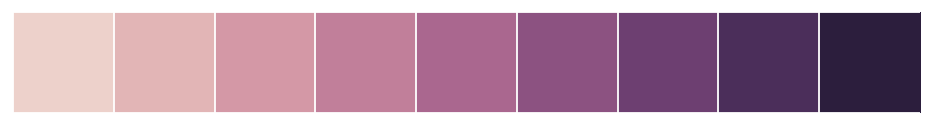

In [14]:
sns.choose_cubehelix_palette()

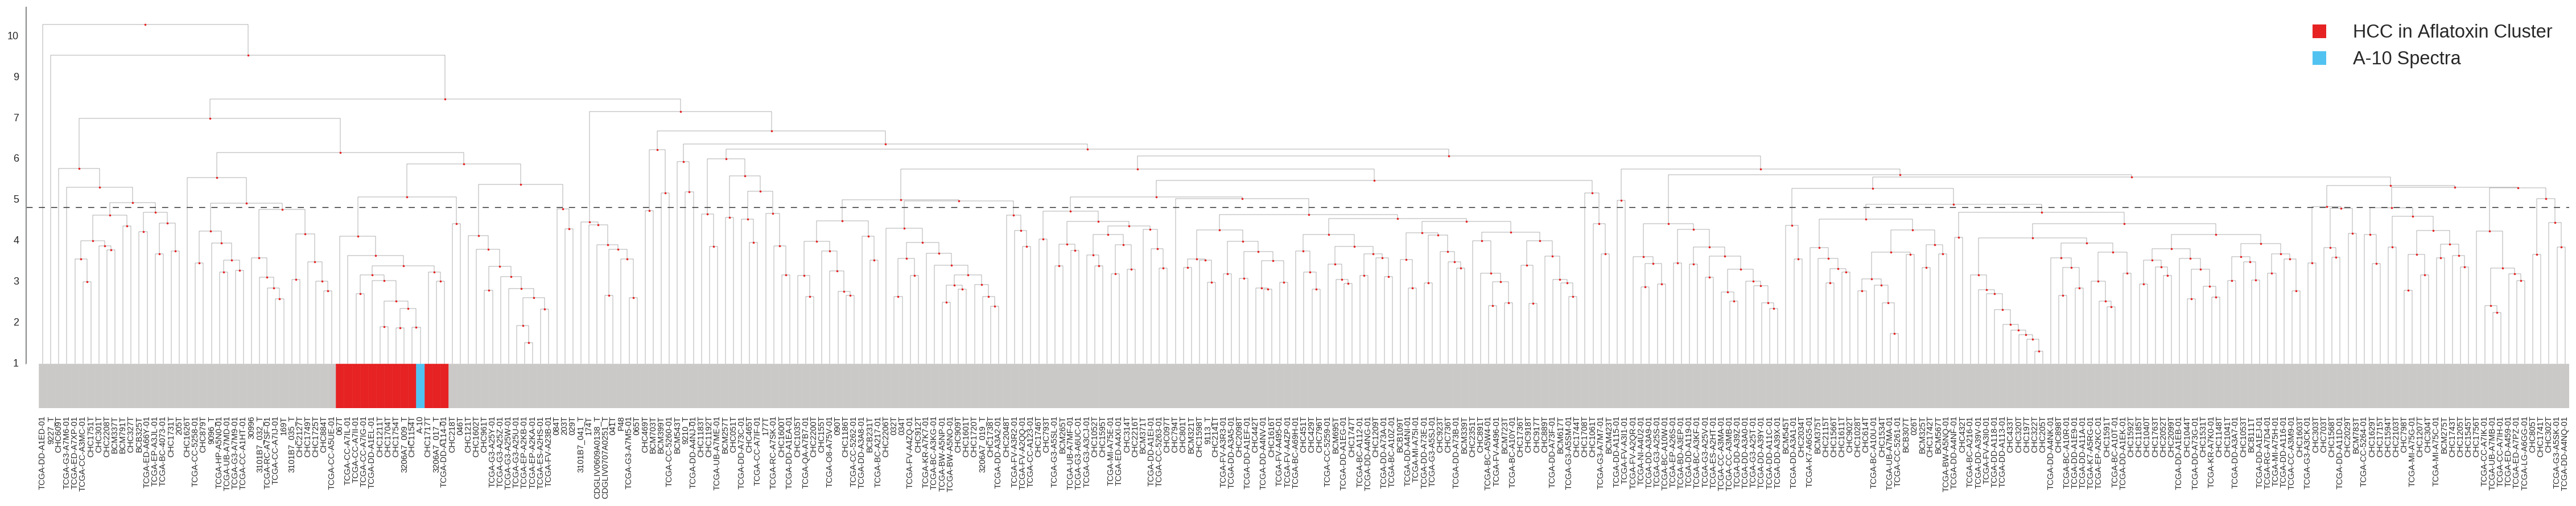

In [38]:
from collections import defaultdict
import numpy
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, set_link_color_palette
try:
    from fastcluster import linkage
except ImportError:
    from scipy.cluster.hierarchy import linkage
import seaborn as sns
from siglib.figures import colored_bins
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import rgb2hex, colorConverter

import seaborn as sns
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage

from siglib.figures import sig_palette

set_link_color_palette([sig_palette['almost_black']])
sns.set_style('white')

labels = []
data = []

for sample in results:
    labels.append(sample.name)
    data.append(sample.spectrum_count.normalized_proportion(normal))
    

data.append(list(C10))
labels.append('A-10')



df = pd.DataFrame(data, index=labels)
link = linkage(df, method='weighted', metric='cosine')

fig = plt.figure(figsize=(35, 7))
gs = gridspec.GridSpec(2, 1, height_ratios=[8,1], hspace=0)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.axhline(0.3825, color=sig_palette['almost_black'], linewidth=0.8, linestyle='--')

#matplotlib.rcParams['lines.linewidth'] = 0.65
matplotlib.rcParams['lines.linewidth'] = 0.2

dend_colors = [sig_palette['almost_black']] * (2*len(data)-1)
to_color = [6, 7, 10, 19, 32, 41, 76, 84, 99, 107, 127, 164, 217]

#for color in to_color:
#    dend_colors[len(data) + color] = sig_palette['red']
den = dendrogram(link, ax=ax1, labels=df.index, link_color_func=lambda x: dend_colors[x],
                 color_threshold=0, no_labels=True)
for z, (i, d) in enumerate(zip(den['icoord'], den['dcoord'])):
    x = 0.5 * sum(i[1:3])
    y = d[1]
    ax1.plot(x, y, 'o', markersize=2, color=sig_palette['red'])
    #ax1.annotate("%.3g" % z, (x, y), xytext=(0, -8),
    #             textcoords='offset points',
    #             va='top', ha='center', fontsize=9)

import numpy as np
ax1.set_yticklabels([1, 2, 3, 4, 5, 6, 7, 9, 10])

#it = iter(map(label_colors.__getitem__, d['ivl'])[-2::-1])
def f(x):
    return it.next()

row_length = len(samples.values())
row_colors = []


#for sample in den['ivl']:
#    if any(name in sample for name in aflatoxin_cluster_names):
#        row_colors.append(sig_palette['red'])
#    else:
#        row_colors.append(sig_palette['grey'])

for x in range(len(data)):
    if x == 47:
        row_colors.append(sig_palette['blue'])
    elif x > 36 and x < 51:
        row_colors.append(sig_palette['red'])
    else:
        row_colors.append(sig_palette['grey'])

offset = .05
ax1.set_xlim(-(offset * len(data)), ax1.get_xlim()[1])


handles, labels = ax1.get_legend_handles_labels()
display = (0,1,2)

#Create custom artists
simArtist = plt.Line2D((0,1),(0,0), color=sig_palette['red'], marker='s', markersize=13, linestyle='')
anyArtist = plt.Line2D((0,1),(0,0), color=sig_palette['blue'], marker='s', markersize=13, linestyle='')

#Create legend from custom artist/label lists
ax1.legend([simArtist,anyArtist],
           ['HCC in Aflatoxin Cluster', 'A-10 Spectra'],
           prop={'size':18})
ax1.spines['left'].set_color(sig_palette['darkgrey'])

colored_bins(len(den['ivl']), ax=ax2, colors=row_colors, labels=den['ivl'])
plt.xticks(rotation=90)
no_spine = {'top': True, 'bottom': True, 'right': True}
sns.despine(**no_spine);
from siglib.learning import get_cluster_classes
#get_cluster_classes(den)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xlim(-(offset /10), ax2.get_xlim()[1])
ax2.get_xaxis().set_visible(True)
_ = ax2.set_xticklabels(den['ivl'], fontsize=8)
fig.tight_layout()
plt.savefig('cluster.pdf', dpi=600)

In [16]:
new_cluster = den['ivl'][37:51]
new_cluster.pop(10)
new_cluster
print(len(den['ivl']))

315


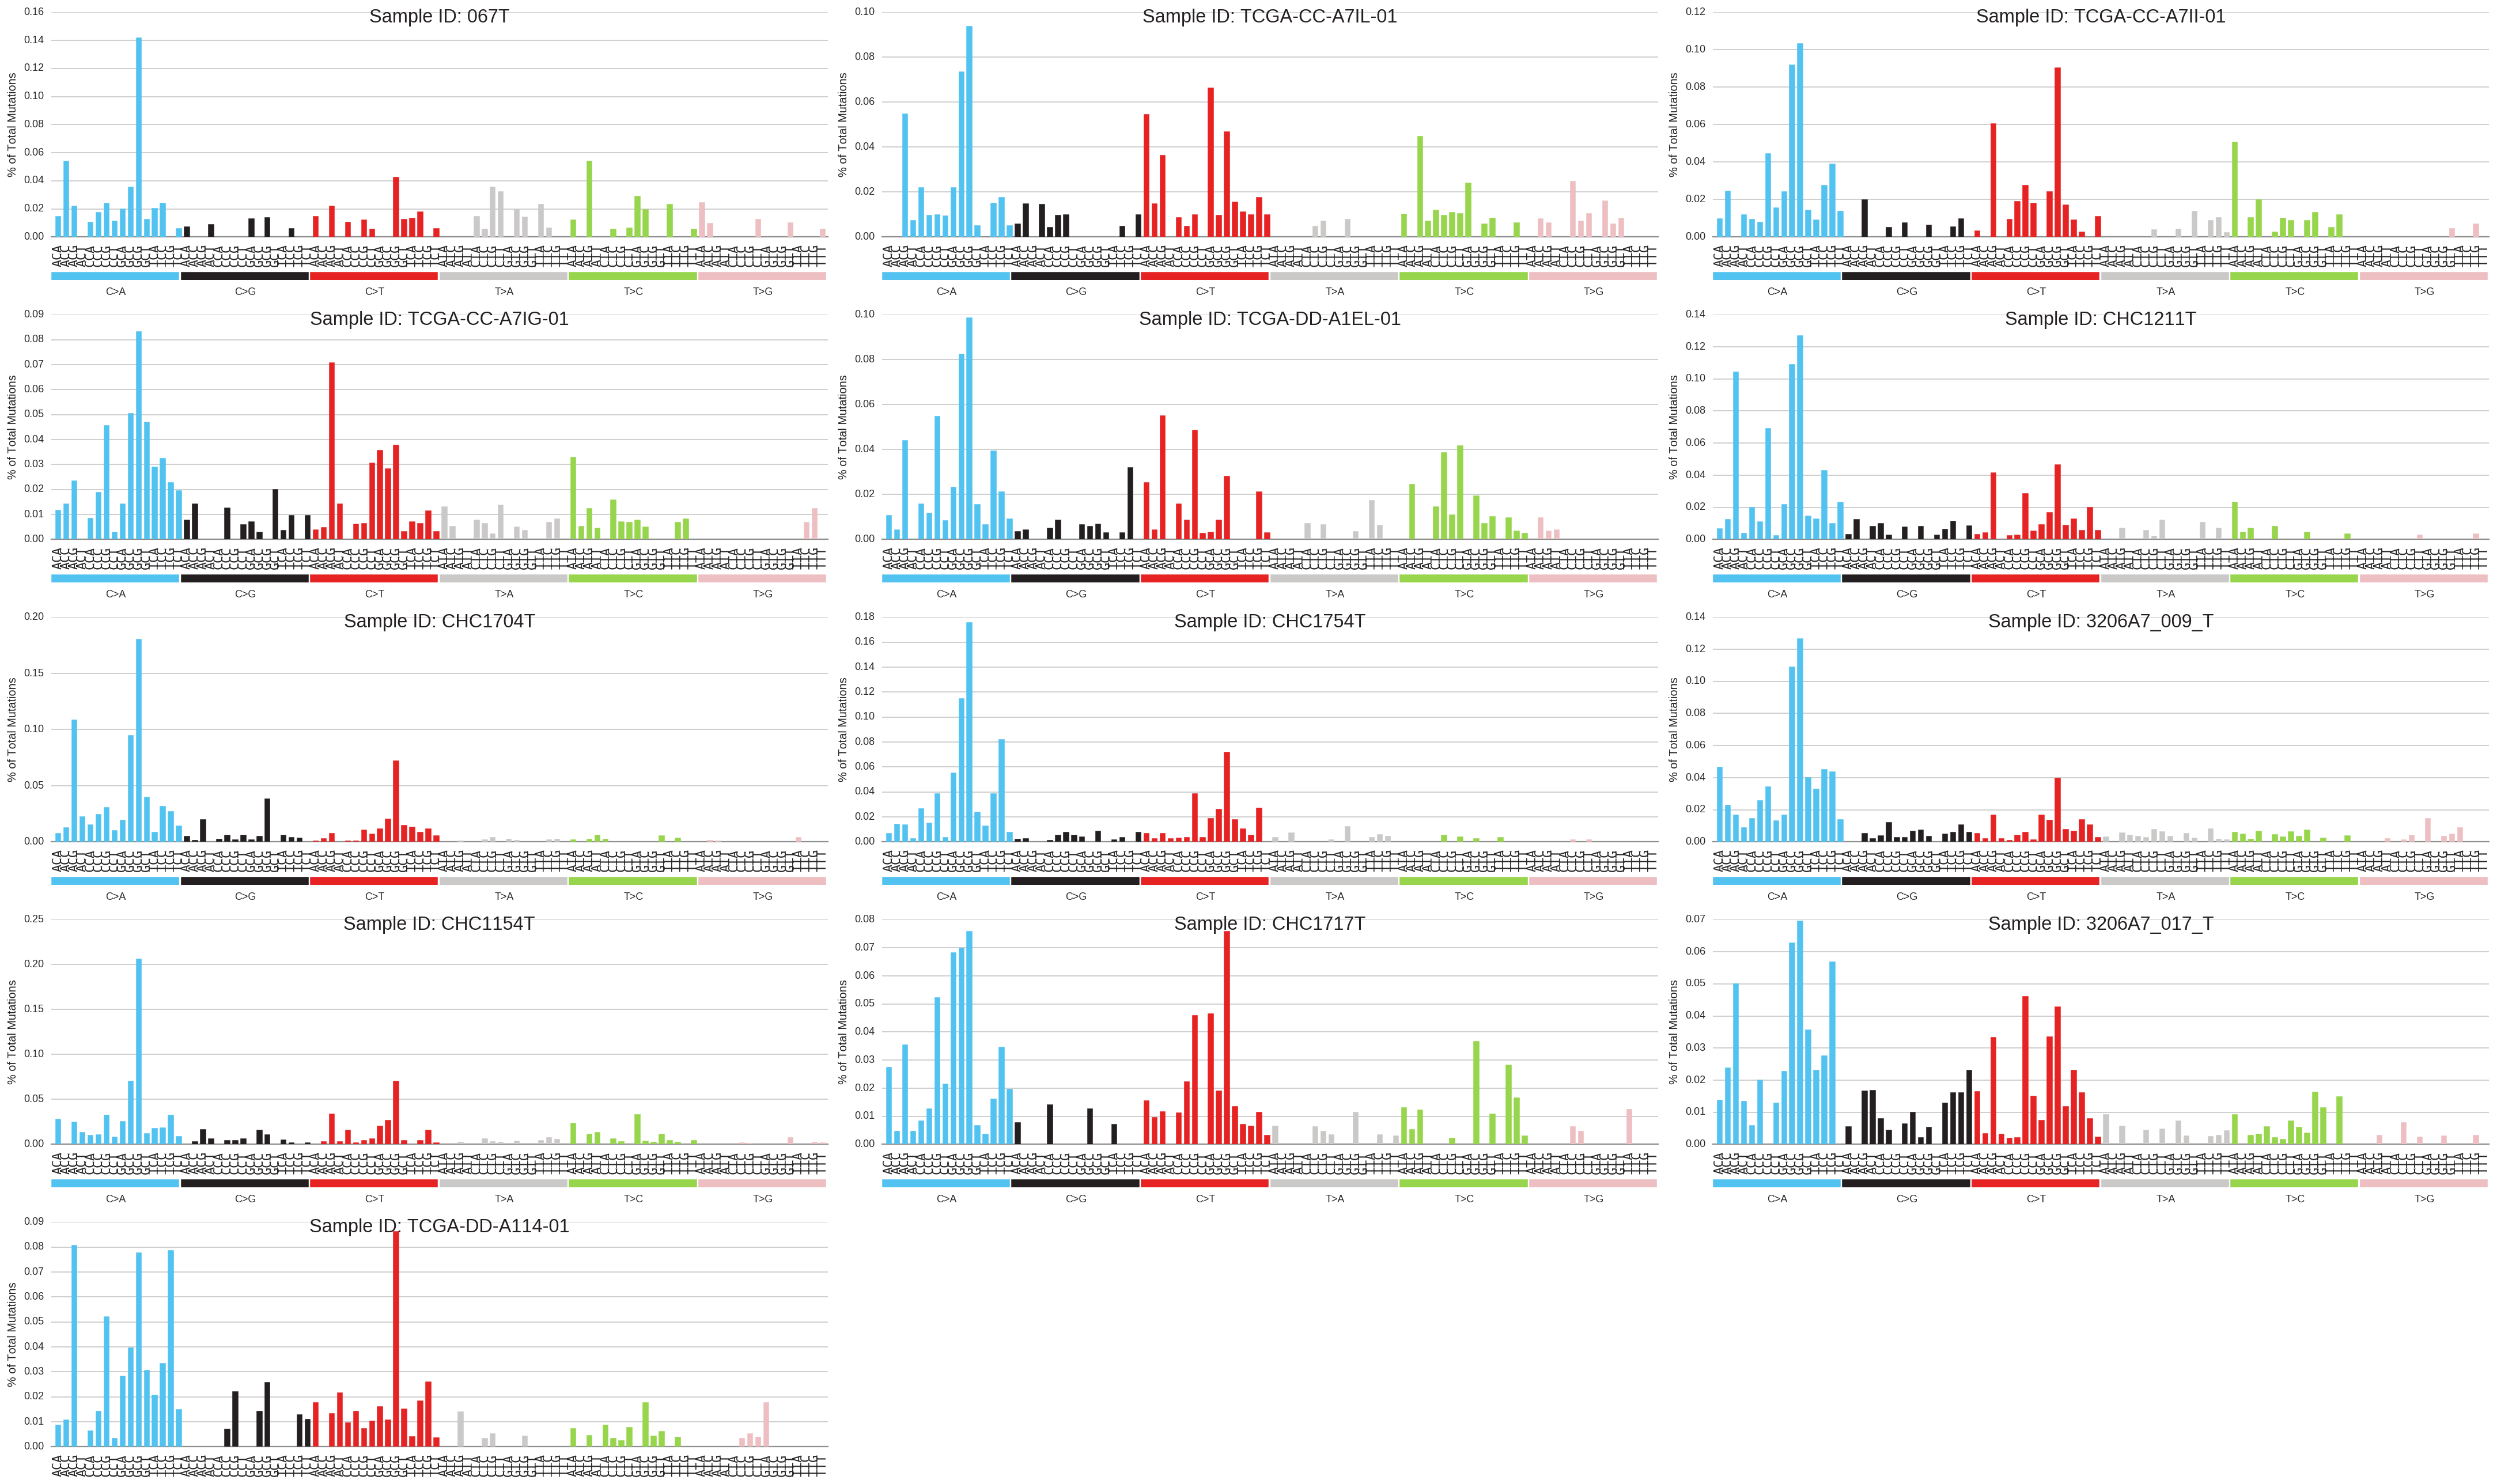

In [45]:
from siglib.figures import spectrum_map
from itertools import repeat
from siglib.utils import py_labels
_, labels = list(zip(*merged_samples[special].spectrum_count.keys()))
spectrum_map(3, 5, dpi=450,
                         xlabels=list(repeat(labels, len(new_cluster))),
                         labels=py_labels,
                         heights=[merged_samples[name].spectrum_count.normalized_proportion(normal) for name in new_cluster],
                         titles=['Sample ID: ' + x + '\n' for x in new_cluster])
plt.savefig('spectras.pdf', dpi=450)




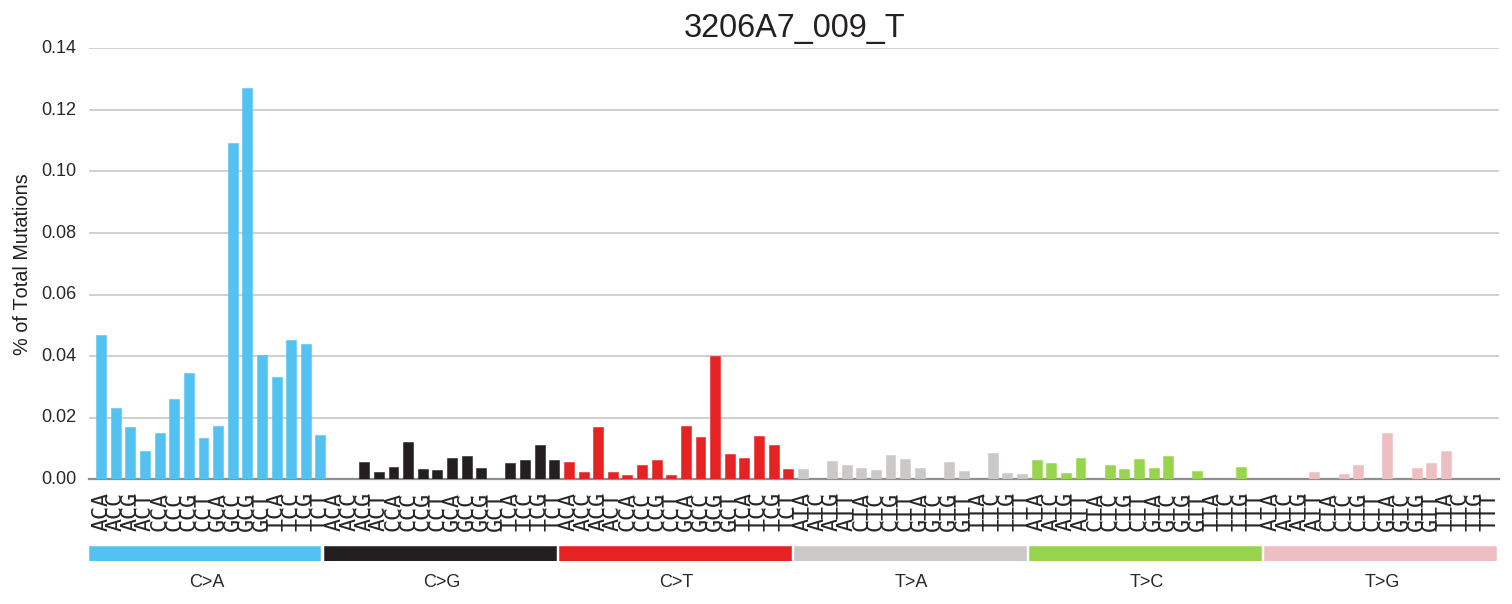

In [37]:
special = '3206A7_009_T'
_, labels = list(zip(*merged_samples[special].spectrum_count.keys()))

spectrum_map(1, 1, dpi=450,
                         xlabels=[labels],
                         labels=py_labels,
                         heights=[merged_samples[special].spectrum_count.normalized_proportion(normal)],
                         titles=[special + '\n\n'])
plt.savefig(special + '.pdf', dpi=450)